# Reciprocity and sensitivity kernels for sea level fingerprints

This notebook illustrates the reciprocity relations discussed in the paper by Al-Attar *et al.* (2023)
 of the same name which is soon to be submitted. In particular, this notebook includes code used to generate 
 all the figures included within that paper. Note that all quantities within the calculations have SI units, but the form of these units is not always shown.

## Setting up the codes

First, we load in the necesarry Python modules. The module ```SLmod.py``` contains much of the code needed for the calculations.

In [123]:
%load_ext autoreload
%autoreload 2

# import libraries
import numpy as np
import matplotlib.pyplot as plt
import pyshtools as pysh
import SLmod as SL
from numpy import pi as pi

#set plotting parameters
plt.rc('xtick', labelsize=18) 
plt.rc('ytick', labelsize=18) 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rcParams['figure.figsize'] = [16, 8]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Now we read in the present day distribution of sea level and ice. This is taken from the ice6g model of:

https://agupubs.onlinelibrary.wiley.com/doi/full/10.1002/2014JB011176

The values of the fields are interpolated onto a Gauss Legendre grid at the chosen expansion order. Note that for the calculations in this notebook L = 256 or higher is a sensible value. The maximum possible is L = 1024, this being set by the Love numbers that have been pre-calculated and are read in below. The code also works out the ocean function from sea level and ice thickness. Note that the defintion of the ocean function calculation does not account for isolated regions below sea level. As a result, the Caspian sea is regarded as part of the oceans. This could be readily fixed, but the effects are small and are not important for our present purposes.

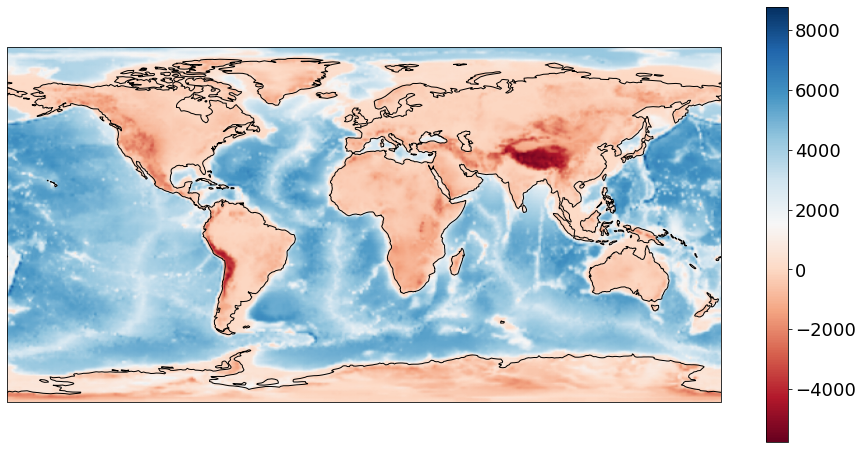

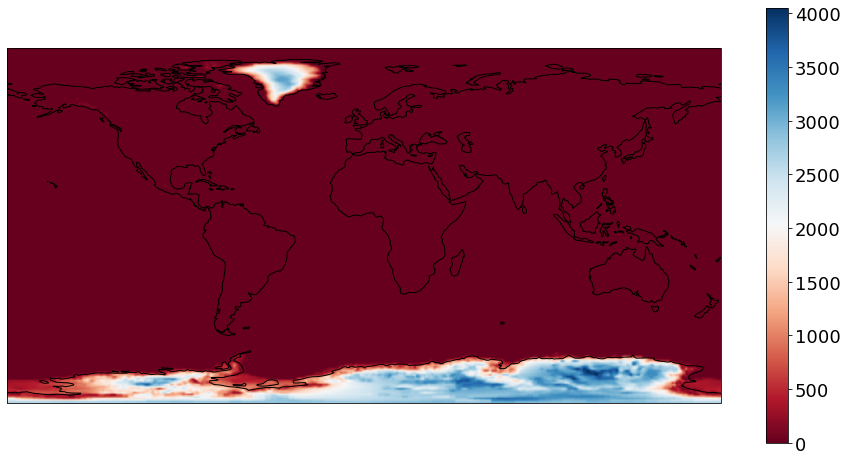

fraction of surface which is ocean =  0.712960233719624


In [124]:
# set the truncation degree
L=256

# read in the present day sea level and ice thickness
sl0,ice0 = SL.get_sl_ice_data(L)

# plot these fields
SL.plot(sl0,title = 'present day sea level')
SL.plot(ice0,title = 'present day ice thickness')

# compute the ocean function
C = SL.ocean_function(sl0,ice0)

# work out the ocean area and check the value
A = SL.surface_integral(C)
A_earth = 4*pi*SL.b**2
print('fraction of surface which is ocean = ',A/A_earth)

## Solving the sea level equation to make a synthetic data set

Our first task is to solve the sea level equation for a given change to the ice thickness. For 
definiteness, we will melt a uniform fraction from the Greenland ice sheet (strictly, the code considers
all northern hemisphere ice within the model as this is easiest to implement). Writing $I_{0}$ for 
the initial thickness, and $I$ for the change, we assume that
\begin{equation}
I = -0.01\,I.
\end{equation}
Such a choice is arbitrary and the codes below do not depend upon it. 

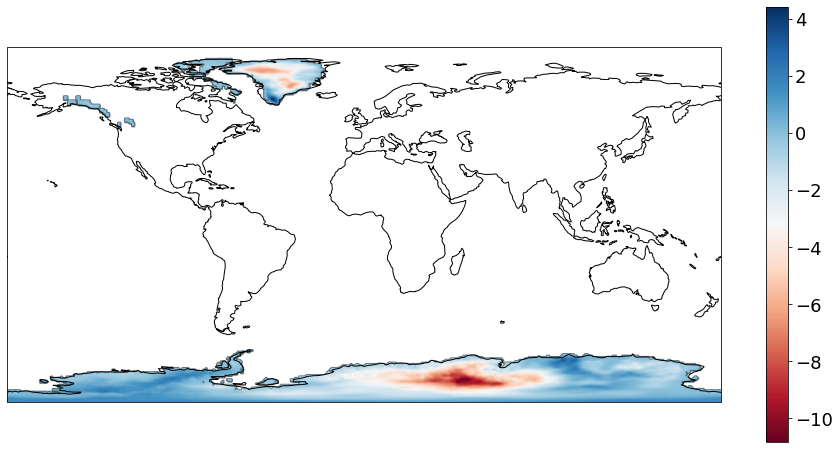

iteration =  1 relative change =  0.0195234316312488
iteration =  2 relative change =  0.002526248898647562
iteration =  3 relative change =  0.00044788562995280067
iteration =  4 relative change =  9.299403547979141e-05
iteration =  5 relative change =  2.1123613413231973e-05
iteration =  6 relative change =  5.111734522349387e-06
iteration =  7 relative change =  1.302878668881116e-06
iteration =  8 relative change =  3.4823168389574455e-07
iteration =  9 relative change =  1.0179924735024092e-07
iteration =  10 relative change =  3.0421555154459766e-08
iteration =  11 relative change =  9.259082626894628e-09


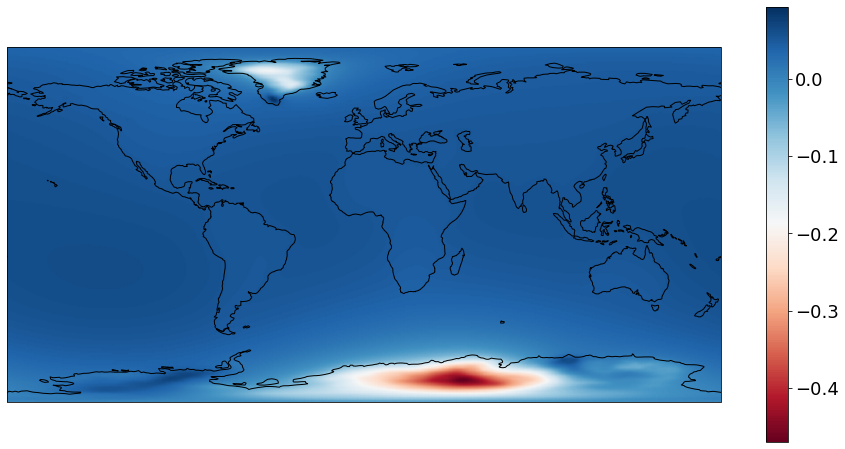

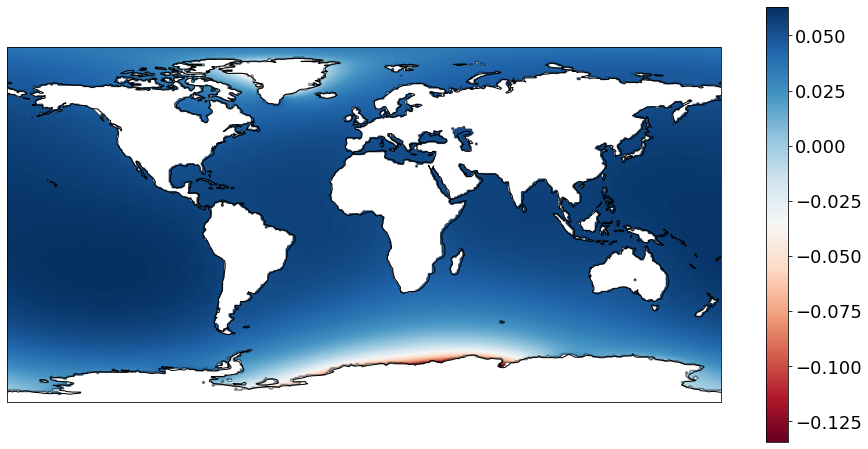

In [174]:
# set geometry for northern and southern hemisphere contributions
Q = SL.sobolev_covariance(L,s = 2,mu=0.2)
zeta_north = SL.rhoi*(1-C)*SL.zero_southern_hemisphere(ice0)*SL.random_field(Q)
zeta_south = SL.rhoi*(1-C)*SL.zero_northern_hemisphere(ice0)*SL.random_field(Q)

# normalise by GMSL contributions
GMSL_north = SL.bathtub(C,zeta_north)
GMSL_south = SL.bathtub(C,zeta_south)

zeta_north /= GMSL_north
zeta_south /= GMSL_south

# set the target value of GMSL
GMSL = 0.05

# set the northern and southern fractions
f_north = 0.2
f_south = 1.-f_north

# set the combined ice load
zeta = GMSL*(f_north*zeta_north + f_south*zeta_south)

# plot the result with suitable mask
ice_mask = SL.ice_mask(sl0,ice0)
SL.plot(ice_mask*zeta/SL.rhoi,title = 'change in ice thickness')

# solve the fingerprint problem
sl,u,phi,om,psi = SL.fingerprint(C,zeta)
ocean_mask = SL.ocean_mask(sl0,ice0)

# plot the result globally
SL.plot(sl,title = 'change in sea level')
# plot the result globally
SL.plot(ocean_mask*sl,title = 'change in sea level over the oceans')



Using the change in ice thickness, we can define the corresponding direct load
\begin{equation}
\zeta = \rho_{i} \,(1-C) \, I, 
\end{equation}
with $\rho_{i}$ the density of ice. This load is then passed to a function for solving the sea level equation to return the change in sea level, $SL$, the vertical displacement, $u$, the change in surface gravitational potential, $\phi$, the perturbation to the rotation vector $\omega$, and the change in centrifugal potential, $\psi$. Note that within these calculations the rotational perturbation is assumed to lie entirely within the plane orthogonal to the reference rotation axis. This is done because the component along the rotation axis is signigicantly smaller. However, the theoretical results to be demonstrated do not depend on such an approximation, and remain valid in either case. Here we also compute the mean sea level change, as defined by
\begin{equation}
GMSL = -\frac{\rho_{i}}{\rho_{w} A}\int_{\partial M} (1-C) \,I \, \mathrm{d} S,
\end{equation}
for later reference.

## Determining the sensitivity kernel for sea level at a given location

If we take the adjoint direct load to be
\begin{equation}
\zeta^{\dagger}(\mathbf{x}) = \delta(\mathbf{x},\mathbf{x}_{0}), 
\end{equation}
then the reciprocity theorem reduces to
\begin{equation}
SL(\mathbf{x}_{0}) = \int_{\partial M} SL^{\dagger} \, \zeta \, \mathrm{d} S, 
\end{equation}
which shows that the function derivative (or sensitivity kernel) of $SL(\mathbf{x}_{0})$
with respect to $\zeta$ is just $SL^{\dagger}$ as calculated from the delta function load.
The code below first solves the fingerprint problem for the point load to obtain $SL^{\dagger}$.

iteration =  1 relative change =  0.007498800294154418
iteration =  2 relative change =  0.00028322888822820134
iteration =  3 relative change =  3.5833581908738264e-05
iteration =  4 relative change =  7.0167958563502436e-06
iteration =  5 relative change =  1.5299507135951093e-06
iteration =  6 relative change =  3.593374118360069e-07
iteration =  7 relative change =  9.045170875441309e-08
iteration =  8 relative change =  2.427644318548086e-08
iteration =  9 relative change =  6.950019017976154e-09


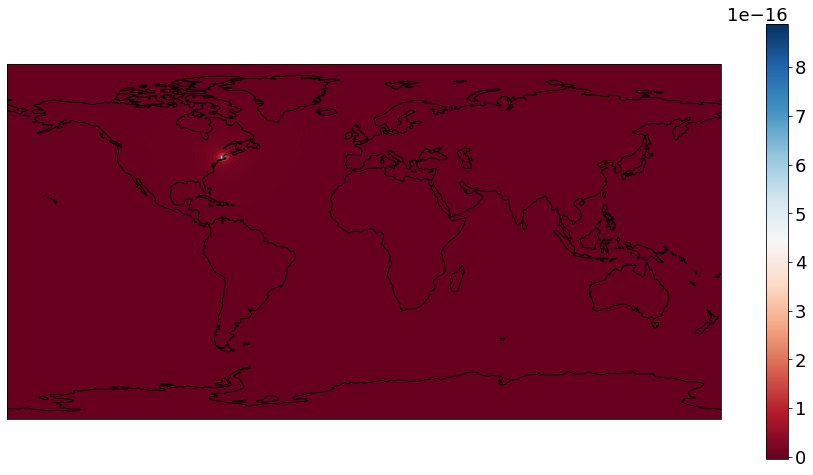

direct sea level value =  0.04719336097398562
left hand side         =  0.047193360973985674
right hand side        =  0.047193365136833525
relative difference    =  8.820833619896401e-08


In [175]:
# set the observation point to Boston
lat =  42.3601
lon = -71.0589

# compute the adjoint load
zeta_d,_,_,_ = SL.sea_level_load(L,lat,lon,angle = 0.)

# solve the sea level equation for SL^{\dagger} and plot
sl_d,_,_,_,_ = SL.fingerprint(C,zeta_d)
SL.plot(sl_d,title = 'sensitivity kernel w.r.t. direct load')


# set the value of sea level directly from the field 
sl_direct = SL.point_evaluation(sl,lat,lon)

# evaluate the sea level by integration against the delta load
lhs = SL.surface_integral(zeta_d*sl)

# now get the value by integrating the sensitivity kernel against the direct load
rhs = SL.surface_integral(sl_d*zeta)

# print the values out along with the relative difference
print('direct sea level value = ',sl_direct)
print('left hand side         = ',lhs)
print('right hand side        = ',rhs)
print('relative difference    = ', np.abs((lhs-rhs)/lhs))


Recalling that the direct load takes the form $\zeta = \rho_{i} (1-C) I$ within the physical problem, 
we can also express the sea level at the observation point as
\begin{equation}
SL(\mathbf{x}_{0}) = \int_{\partial M} \rho_{i}\, (1-C)\, SL^{\dagger} \, I \, \mathrm{d} S, 
\end{equation}
which shows that the sensitivity kernel with respect to $I$ is given by
\begin{equation}
K =  \rho_{i}\, (1-C)\, SL^{\dagger},
\end{equation}
and this is plotted within the following code with the zero values in the oceans masked out for clarity.


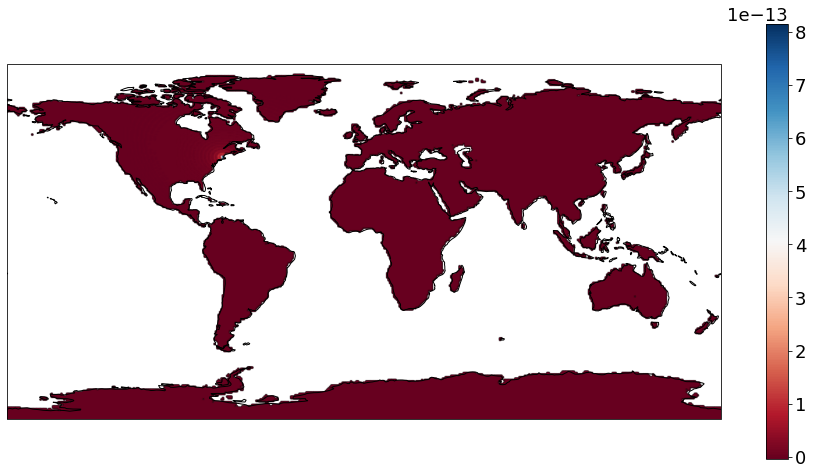

In [176]:
# define and plot the sensitivity kernel with respect to ice thickness
K = SL.rhoi*(1-C)*sl_d
land_mask = SL.land_mask(sl0,ice0)
SL.plot(land_mask*K,title = 'sensitivity kernel w.r.t ice thickness')

An issue here is that this function captures sensitivity to changes in ice thickness at all locations where there *could* be grounded ice. But, of course, we only really care about the sensitivity where there is ice, and hence it is useful to projection this function onto regions where ice is currently found. Within this figure, the location of the point measurement is shown by a red dot.

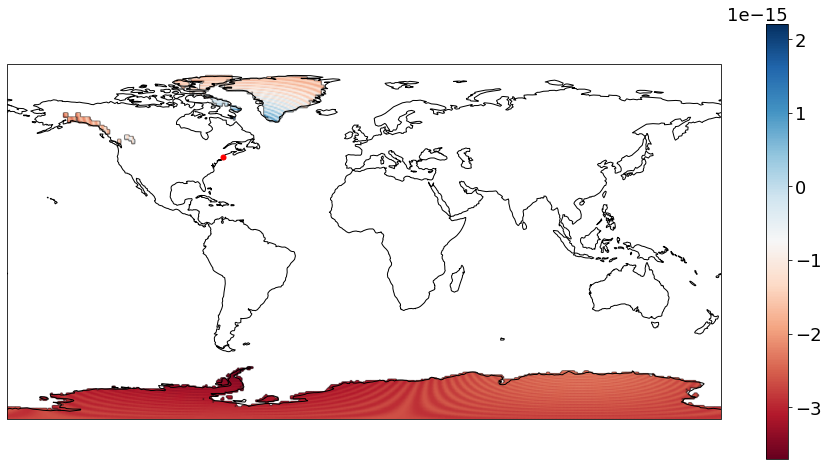

In [177]:
# re-define the kernel such that it is non-zero only where there is grounded ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,title='sensitivity kernel projected onto glaciated regions',marker = [lat,lon])

The issue now is that the kernel is obviously quite ringy, and it is not clear if such behaviour is physically meaningful. What is happening is that the delta load is formed from a truncated spherical harmonic expansion. There is, therefore and errir that is restricted to degrees greater than $L$, and this is what causes the ringing. Within many practical applications, this ringing is of no significance. But for visualisation purposes, it can be removed by smoothing the delta function over a desired length-scale. In practice, this means that instead of measuring sea level at a point, we are averaging it's value over a set distance about the observation point. Because sea level changes calculated for realistic ice loads are quite smooth, such an averaging is a reasonable thing to do. The code below redoes the calculations above to obtain the sensitivity kernel for the ice load, but using a smoothed delta function over a width of one degree about the observation point. 

iteration =  1 relative change =  0.013156455848417114
iteration =  2 relative change =  0.0005963356774333958
iteration =  3 relative change =  7.416530933911268e-05
iteration =  4 relative change =  1.4484835246314533e-05
iteration =  5 relative change =  3.1554593040785355e-06
iteration =  6 relative change =  7.406044139628621e-07
iteration =  7 relative change =  1.8630939252106086e-07
iteration =  8 relative change =  4.997681523057477e-08
iteration =  9 relative change =  1.4295162138337077e-08
iteration =  10 relative change =  4.3696084481859024e-09


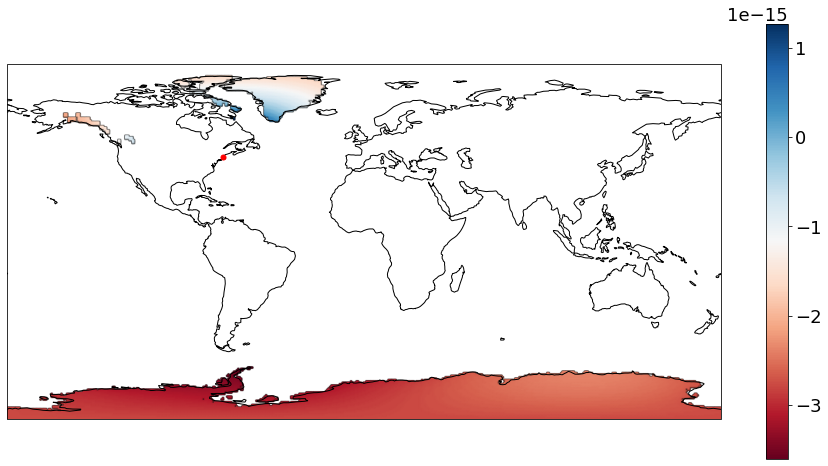

In [178]:
# compute the adjoint load
zeta_d,_,_,_ = SL.sea_level_load(L,lat,lon,angle = 1.)

# solve the sea level equation for SL^{\dagger} and plot
sl_d,_,_,_,_ = SL.fingerprint(C,zeta_d)

# set and plot the kernel projected onto regions of grounded ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,title = 'sensitivity kernel for sea level measurement',marker = [lat,lon])


The form of this sensitivity kernel over Greenland can be compared to the result shown in Fig.1 of Mitrovica *et al.* (2018) for Boston that where obtained using a comparatively costly finite-difference approach. 
With the present method, it is a simple matter to compute such kernels for any desired location. Here, for example, Thessaloniki  which was also considerd by Mitrovica *et al.* (2018)

iteration =  1 relative change =  0.009206636502281174
iteration =  2 relative change =  0.00029720302373047126
iteration =  3 relative change =  3.389706766312653e-05
iteration =  4 relative change =  7.222188347441169e-06
iteration =  5 relative change =  1.9830415157548222e-06
iteration =  6 relative change =  5.740496303396189e-07
iteration =  7 relative change =  1.6978144992246432e-07
iteration =  8 relative change =  5.1236043391148413e-08
iteration =  9 relative change =  1.5731057067282e-08
iteration =  10 relative change =  4.8985681118379805e-09


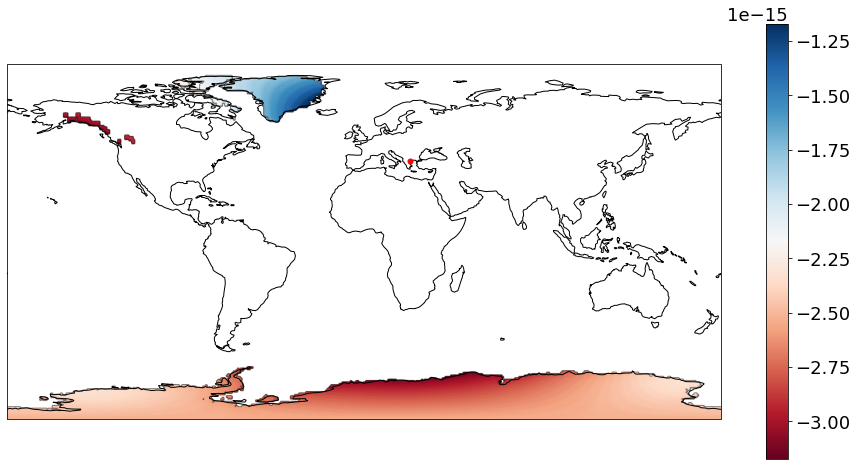

In [179]:
# calculate kernel for Thessaloniki
lat = 40.6401
lon = 22.9444
zeta_d,_,_,_ = SL.sea_level_load(L,lat,lon,angle = 1.)
sl_d,_,_,_,_ = SL.fingerprint(C,zeta_d)
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,title = 'sensitivity kernel for sea level measurement',marker = [lat,lon])

# Checking the generalised form of the reciprocity theorem

To obtain sensitivity kernels for more general observables (e.g. vertical displacements, or sea surface
height changes), it is necessary to consider a generalisation of the fingerprint problem that includes additional non-physical loads. The corresponding reciprocity theorem is given by
\begin{equation}
  \int_{\partial M} SL^{\dagger} \,\zeta \,\mathrm{d} S
  -\frac{1}{g} \int_{\partial M} [\zeta_{u}\mathbf{u}^{\dagger}\cdot \nabla \Phi + \zeta_{\phi} (\phi^{\dagger}
    + \psi^{\dagger})] \,\mathrm{d} S - \frac{1}{g}\mathbf{k}\cdot \omega^{\dagger} 
    = \int_{\partial M} SL \,\zeta^{\dagger} \,\mathrm{d} S
  -\frac{1}{g} \int_{\partial M} [\zeta_{u}^{\dagger}\mathbf{u}\cdot \nabla \Phi + \zeta_{\phi}^{\dagger} (\phi
    + \psi)] \,\mathrm{d} S - \frac{1}{g}\mathbf{k}^{\dagger}\cdot \omega. 
\end{equation}
When $SL$ is obtained through the standard fingerprint problem, this identity simplifies to
\begin{equation}
 \int_{\partial M} SL^{\dagger} \,\zeta \,\mathrm{d} S
    = \int_{\partial M} SL \,\zeta^{\dagger} \,\mathrm{d} S
  -\frac{1}{g} \int_{\partial M} [\zeta_{u}^{\dagger}\mathbf{u}\cdot \nabla \Phi + \zeta_{\phi}^{\dagger} (\phi
    + \psi)] \,\mathrm{d} S - \frac{1}{g}\mathbf{k}^{\dagger}\cdot \omega, 
\end{equation}
which is sufficient to determine the sensitivity kernels for all cases of practical interest. A number of examples are given below, with the validity of the kernel being checked by directly integrating evaluating the observable using the results of the fingerprint calculation for Greenland done above.



### Case 1: Vertical displacement measurement

If the observation point is $\mathbf{x}_{0}$, then the adjoint loads are:
\begin{equation}
\zeta^{\dagger} = 0, \quad \zeta_{u}^{\dagger}(\mathbf{x})  = -\delta(\mathbf{x},\mathbf{x}_{0}), 
\quad \zeta_{\phi}^{\dagger} = 0, \quad \mathbf{k}^{\dagger} = \mathbf{0}.
\end{equation}
The following code implements and checks the results in this case. Note that the point load 
has been smoothed over a degree for plotting.

iteration =  1 relative change =  0.004824475782954492
iteration =  2 relative change =  7.940893327069527e-05
iteration =  3 relative change =  1.853709498500912e-05
iteration =  4 relative change =  4.620737370125089e-06
iteration =  5 relative change =  1.1903292178925818e-06
iteration =  6 relative change =  3.172157435743543e-07
iteration =  7 relative change =  8.744286176764194e-08
iteration =  8 relative change =  2.4887620537133234e-08
iteration =  9 relative change =  7.290933535606349e-09

direct displacement value =  0.00037415465243844173
left hand side            =  0.00037416818604887956
right hand side           =  0.0003741546524384328
relative difference       =  3.616985877310869e-05

iteration =  1 relative change =  0.008350225518875584
iteration =  2 relative change =  0.00018634732852444724
iteration =  3 relative change =  4.202633733683778e-05
iteration =  4 relative change =  1.0475867658385429e-05
iteration =  5 relative change =  2.6986410412750824e-06
itera

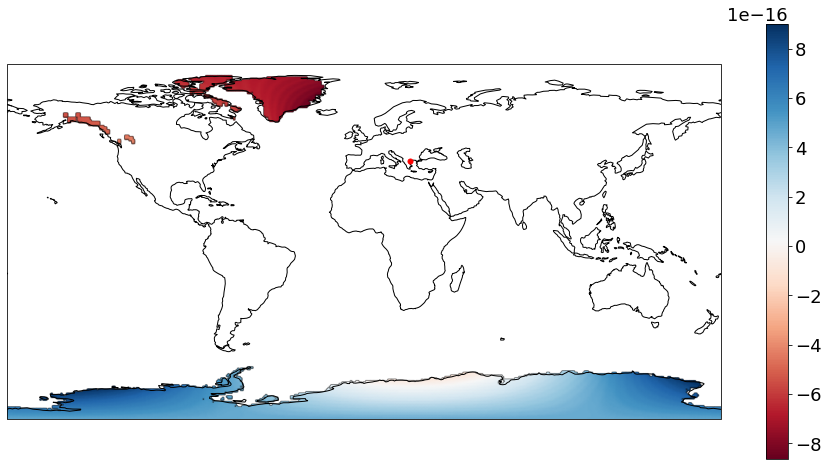

In [180]:
# set the observation point in Thessaloniki
lat = 40.6401
lon = 22.9444
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 0)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the displacement directly
u_lm = u.expand();
u_direct = pysh.expand.MakeGridPoint(u_lm.coeffs,lat,lon+180)

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct displacement value = ',u_direct)
print('left hand side            = ', lhs)
print('right hand side           = ',rhs)
print('relative difference       = ', np.abs((lhs-rhs)/lhs))
print('')


# compute and plot the sensitivity kernel wrt ice thickness, but smoothing the point load
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 1)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,title = 'sensitivity kernel for displacement measurement',marker = [lat,lon])

Now we do a second example at a new location:

iteration =  1 relative change =  0.00229547618848338
iteration =  2 relative change =  0.00012758207329033804
iteration =  3 relative change =  1.595015836108793e-05
iteration =  4 relative change =  2.567478471562643e-06
iteration =  5 relative change =  5.105416650603532e-07
iteration =  6 relative change =  1.130737187552754e-07
iteration =  7 relative change =  2.7400224240315968e-08
iteration =  8 relative change =  7.293638865868796e-09

direct displacement value =  0.0001433710423883197
left hand side            =  0.0001433737201180951
right hand side           =  0.00014337104238833372
relative difference       =  1.867657307881668e-05

iteration =  1 relative change =  0.006689186513777677
iteration =  2 relative change =  0.0003160670125120319
iteration =  3 relative change =  3.782821427281749e-05
iteration =  4 relative change =  6.09278274034289e-06
iteration =  5 relative change =  1.1617797755045551e-06
iteration =  6 relative change =  2.562201083140132e-07
iteration 

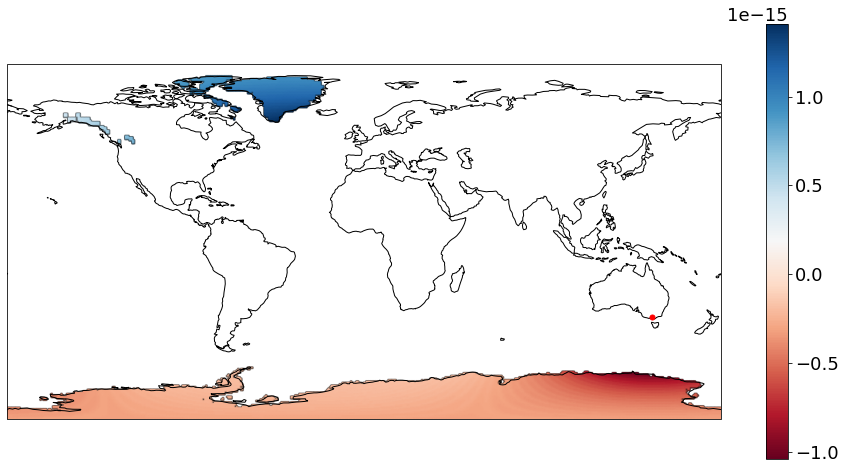

In [181]:
# set the observation point in Melborne
lat = -37.8136
lon = 144.9631
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 0)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the displacement directly
u_lm = u.expand();
u_direct = pysh.expand.MakeGridPoint(u_lm.coeffs,lat,lon+180)

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct displacement value = ',u_direct)
print('left hand side            = ', lhs)
print('right hand side           = ',rhs)
print('relative difference       = ', np.abs((lhs-rhs)/lhs))
print('')


# compute and plot the sensitivity kernel wrt ice thickness, but smoothing the point load
zeta_d,zeta_u_d,zeta_phi_d,kk_d = SL.displacement_load(L,lat,lon,angle = 1)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,title = 'sensitivity kernel for displacement measurement',marker = [lat,lon])

### Case 2: gravitational potential coefficient measurement

If the observation we want to measure the $(l,m)$th coefficient for $l \ge 2$ we set
\begin{equation}
\zeta^{\dagger} = 0, \quad \zeta_{u}^{\dagger}(\mathbf{x})  = 0, 
\quad \zeta_{\phi}^{\dagger} = -g Y_{lm}, \quad \mathbf{k}^{\dagger} = \int_{\partial M}\zeta_{\phi}^{\dagger} \, \mathbf{x} \times
    (\Omega \times \mathbf{x}) \,\mathrm{d} S, 
\end{equation}
with $Y_{lm}$ a fully normalised real spherical harmonic. Note that the value of $\mathbf{k}^{\dagger}$
has been set so as to remove the contribution to the right hand side from $\psi$.


iteration =  1 relative change =  0.12119993366418241
iteration =  2 relative change =  0.014913723109157586
iteration =  3 relative change =  0.0019680030013905438
iteration =  4 relative change =  0.0003216644123907741
iteration =  5 relative change =  6.0200465281315164e-05
iteration =  6 relative change =  1.2793662590225956e-05
iteration =  7 relative change =  3.3084147639307243e-06
iteration =  8 relative change =  9.081893268313863e-07
iteration =  9 relative change =  2.5250707764328586e-07
iteration =  10 relative change =  7.192525768695002e-08
iteration =  11 relative change =  2.104530637909058e-08
iteration =  12 relative change =  6.3131384957043e-09

direct potential value    =  -0.0016132983112794148
left hand side            =  -0.0016132981792711305
right hand side           =  -0.0016132983112794109
relative difference       =  8.182509723747835e-08



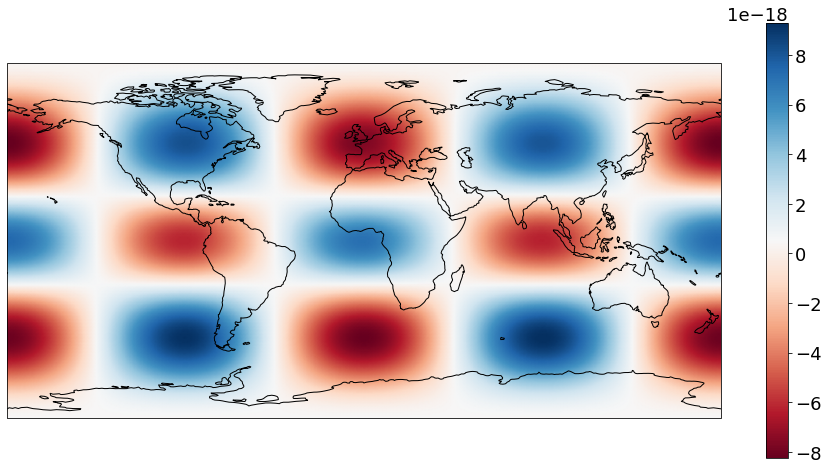

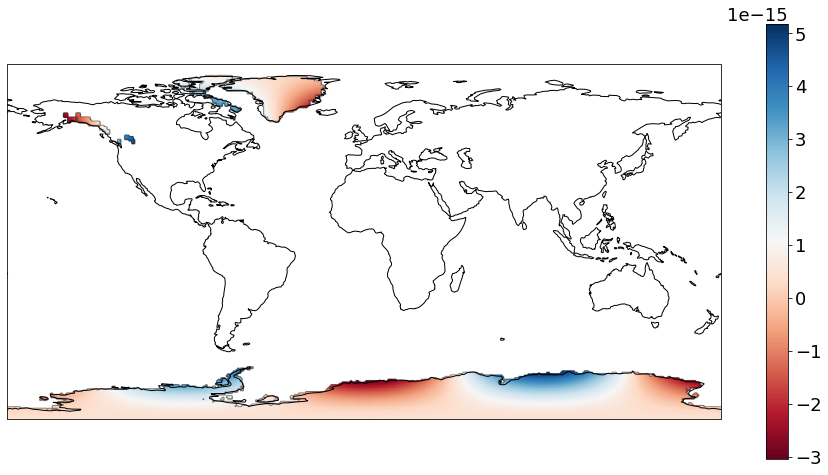

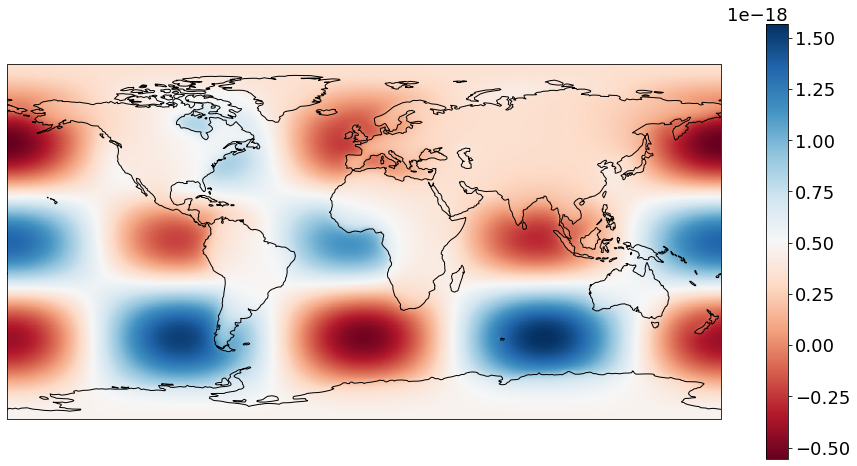

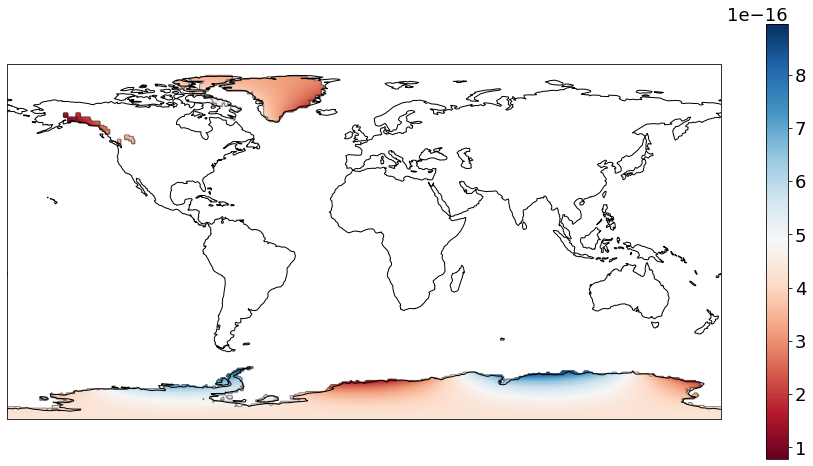

In [182]:
# set the adjoint loads
l = 4
m = 2
zeta_d, zeta_u_d, zeta_phi_d, kk_d = SL.potential_coefficient_load(L,l,m,remove_psi = True)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# get the potential coefficient directly
phi_lm = phi.expand(normalization='ortho')
if(m >= 0):
    phi_direct = phi_lm.coeffs[0,l,m]
else:
    phi_direct = phi_lm.coeffs[1,l,-m]

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct potential value    = ',phi_direct)
print('left hand side            = ',lhs)
print('right hand side           = ',rhs)
print('relative difference       = ',np.abs((lhs-rhs)/lhs))
print('')


# plot the sensitivity kernel wrt zeta
SL.plot(sl_d,title = 'sensitivity kernel for potential coefficient')


# plot the sensitivity kernel wrt ice
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,title = 'sensitivity kernel for potential coefficient')

# get the love numbers
_,k,_,_ = SL.love_numbers(L)

# compute the kernel for a direct load
K_d_lm = pysh.SHCoeffs.from_zeros(lmax=L,normalization = 'ortho')
if(m > 0):
    K_d_lm.coeffs[0,l,m] = k[l]/SL.b**2
else:
    K_d_lm.coeffs[1,l,-m] = k[l]/SL.b**2   
K_d = K_d_lm.expand(grid = 'GLQ')



# plot the sensitivity kernel wrt zeta minus direct kernel
SL.plot((sl_d-K_d),title = 'sensitivity kernel for potential coefficient')


# plot the sensitivity kernel wrt ice
K = SL.rhoi*(1-C)*(sl_d-K_d)*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,title = 'sensitivity kernel for potential coefficient')


## Case 3: Grace load averages

In the spherical harmonic domain, the relation between the total load and the gravitational potential
perturbation is
\begin{equation}
\phi_{lm} = k_{l}\,\sigma_{lm}.
\end{equation}
We consider only $l \ge 2$ as potential coefficients at $l =0,1$ can be assumed to be zero
due to mass conservation and choice of a suitable reference frame. Inversion of this relationship
provides an ostensible means for recovering the surface mass
\begin{equation}
\tilde{\sigma} = \sum_{l\ge 2,m} k_{l}^{-1}\,\phi_{lm}\,Y_{lm}.
\end{equation}
In practice this expression cannot be stably applied, but it is okay so long as the 
expansion is truncated at an appropriate degree. Note that we call this term
$\tilde{\sigma}$ to show that it need not be the true load, $\sigma$. 

Instead of looking at point-values of the estimated load, we can consider spatial averages
over a region of interest. This, in particular, lessens issues with applying the inverse 
relation for large $l$. Suppose we define
\begin{equation}
J =  \int_{\partial M} w\, \tilde{\sigma} \,\mathrm{d} S, 
\end{equation}
for some weighting function $w$. Putting in the definition of  $\tilde{\sigma}$ this 
is seen to equal 
\begin{equation}
J =  -\frac{1}{g}\int_{\partial M} \zeta_{\phi}^{\dagger}\, \phi \,\mathrm{d} S, 
\end{equation}
where we have defined
\begin{equation}
\zeta_{\phi}^{\dagger} = -\frac{g}{b^{2}}\sum_{l\ge 2,m} k_{l}^{-1}\,w_{lm}\,Y_{lm}, 
\end{equation}
with $w_{lm}$ the expansion coefficients of the weighting function. Using this function along with the choices  $\zeta^{\dagger} = 0$, $\zeta_{u}^{\dagger} = 0$ and 
\begin{equation}
\mathbf{k}^{\dagger} = \int_{\partial M}\zeta_{\phi}^{\dagger} \, \mathbf{x} \times
    (\Omega \times \mathbf{x}) \,\mathrm{d} S, 
\end{equation}
we can solve the adjoint problem to obtain $SL^{\dagger}$ and then write
\begin{equation}
 J = \int_{\partial M} SL^{\dagger}\,
 \zeta \,\mathrm{d} S.
\end{equation}
In this way we can understand how such a Grace average is related to the direct loads within the problem. This
idea is implemented below for a simple choice of averaging function, $w$.

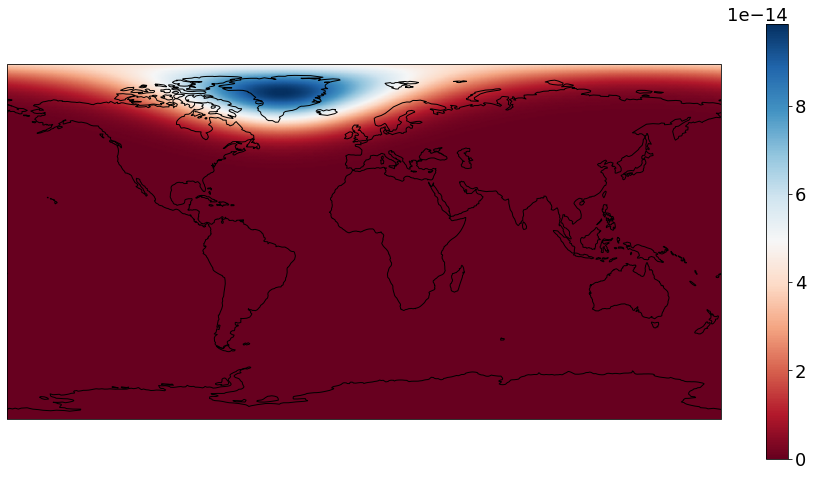

iteration =  1 relative change =  0.06281363327100745
iteration =  2 relative change =  0.006252792935348566
iteration =  3 relative change =  0.0007900993930666505
iteration =  4 relative change =  0.00015834448397327014
iteration =  5 relative change =  3.986006203895005e-05
iteration =  6 relative change =  1.0443518568315106e-05
iteration =  7 relative change =  2.8535379821713304e-06
iteration =  8 relative change =  8.104949346860937e-07
iteration =  9 relative change =  2.380902193473847e-07
iteration =  10 relative change =  7.186223968320765e-08
iteration =  11 relative change =  2.214749428322809e-08
iteration =  12 relative change =  6.933215825926704e-09


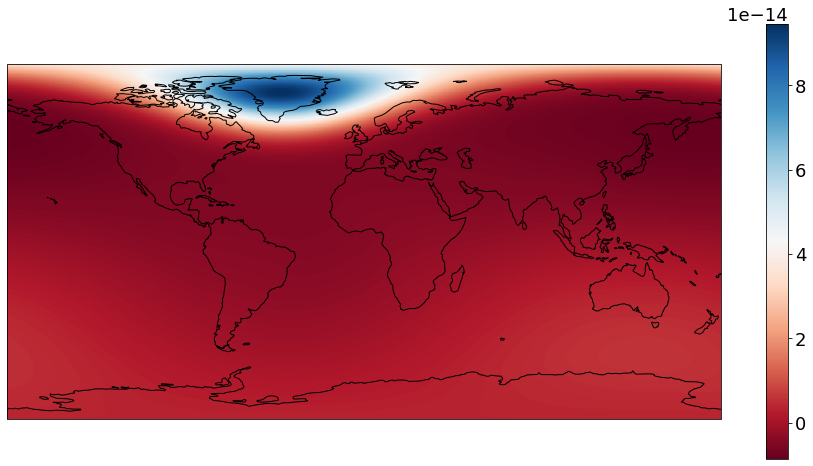

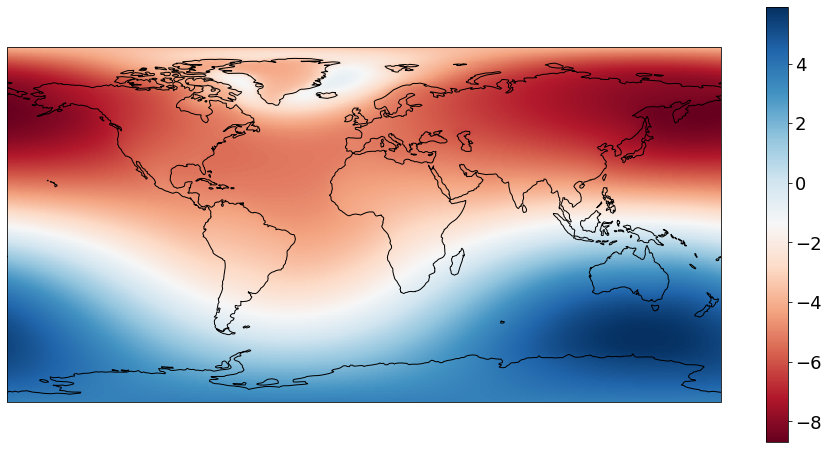

GRACE average of load =  -0.37184119808508
true average of load  =  -0.3385910084142911
relative difference   =  9.820163218895892 %


In [185]:
# define the averaging function as in Wahr et al. (1998)
w = SL.circular_averaging_function(L,r = 1500,lat0 = 75.,lon0 = -42.)
SL.plot(w,title = 'GRACE averaging kernel')


# form the adjoint loads
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.GRACE_average_load(w,LT = 100)

# solve the adjoint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# plot the kernel wrt zeta
SL.plot(sl_d,title = 'sensitivity kernel for GRACE average wrt direct load')

GRACE_average = SL.GRACE_average_measurement(phi,w,LT = 100)/SL.rhow
true_average  = SL.surface_integral(zeta*w)/SL.rhow



# plot the kernel wrt zeta
norm = np.max(np.abs(w.data[:,:]))
SL.plot(100*(sl_d-w)/norm,title = 'percentage difference between the kernels')

print('GRACE average of load = ',GRACE_average)
print('true average of load  = ',true_average)
print('relative difference   = ',100*(GRACE_average-true_average)/true_average,'%')


## Case 4: Spatial average of sea surface height change

Here we consider the observable
\begin{equation}
J = \frac{1}{A_{obs}}\int_{\partial M_{obs}}  SSH \, \mathrm{d} S, 
\end{equation}
where $SSH$ denotes the sea surface height change as might be observed using satellite altimetry, 
the area $\partial M_{obs}$ is the region of the oceans covered by the measurement, and $A_{obs}$
denotes its area. Such an average might be taken as a proxy for global mean sea level change. 
In the calculation below, we assume that the observation area comprises the ice-free oceans lying between $\pm 66$ degrees latitude. For this calculation, we note that the sea surface height change can be expressed
as 
\begin{equation}
SSH = SL + u + \frac{\psi}{g}, 
\end{equation}
where $u$ is the vertical displacement of the solid surface, and $\psi$ the centrifugal potential change. Given this, it follows that the appropriate adjoint loads are
\begin{equation}
\zeta^{\dagger} = \frac{1}{A_{o}}\chi, \quad \zeta_{u}^{\dagger}(\mathbf{x})  = -\frac{1}{A_{o}}\chi, 
\quad \zeta_{\phi}^{\dagger} = 0, \quad \mathbf{k}^{\dagger} = \int_{\partial M}\zeta^{\dagger} \, \mathbf{x} \times
    (\Omega \times \mathbf{x}) \,\mathrm{d} S, 
\end{equation}
where $\chi$ is a function equal to one in the observational area and zero otherwise. 

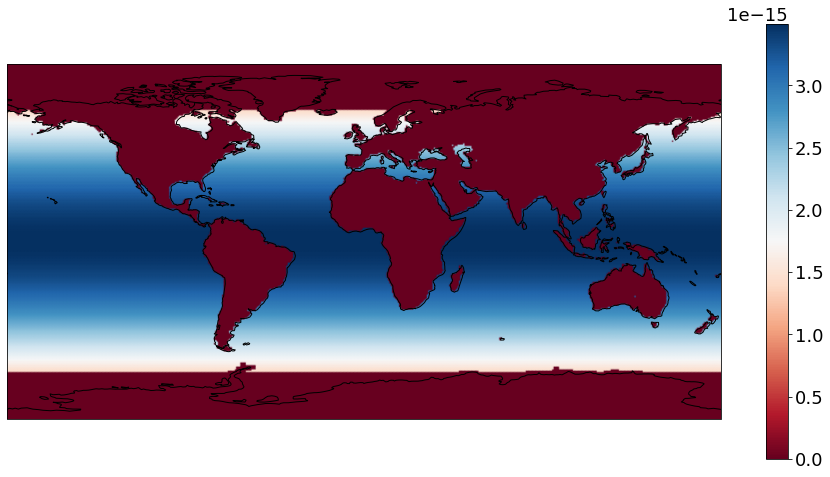

iteration =  1 relative change =  0.010689652452821264
iteration =  2 relative change =  0.0020476926708371773
iteration =  3 relative change =  0.00042358079600778465
iteration =  4 relative change =  9.12784255695483e-05
iteration =  5 relative change =  2.017061385348681e-05
iteration =  6 relative change =  4.540127030323738e-06
iteration =  7 relative change =  1.038773241185549e-06
iteration =  8 relative change =  2.4162732803236446e-07
iteration =  9 relative change =  5.72383386896925e-08
iteration =  10 relative change =  1.3847603568151239e-08
iteration =  11 relative change =  3.433365179381558e-09

direct ssh value     =  0.049119997177413006
left hand side       =  0.049119995916406714
right hand side      =  0.04911999717741302
relative difference  =  2.567195462444627e-08



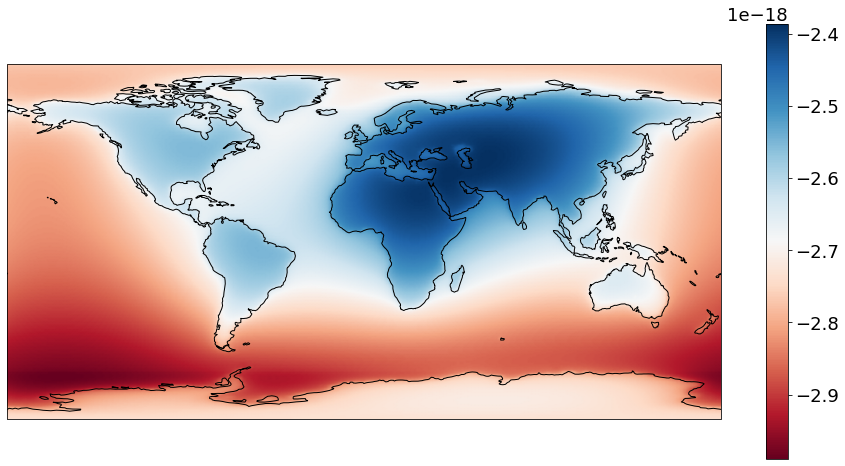

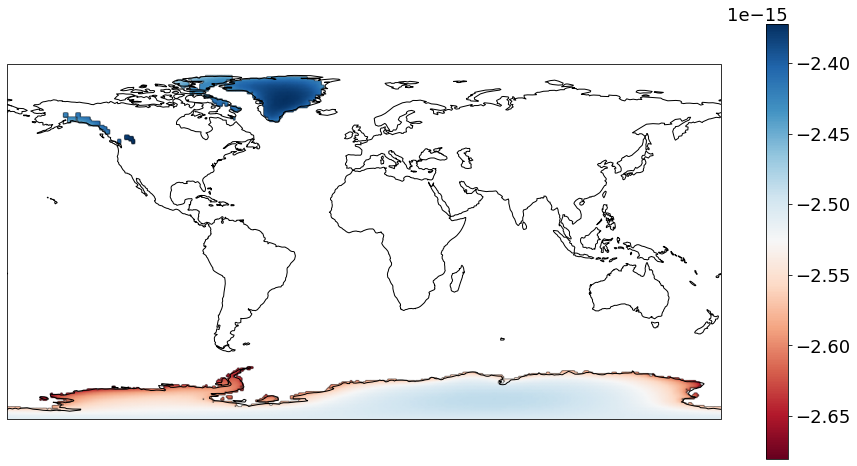

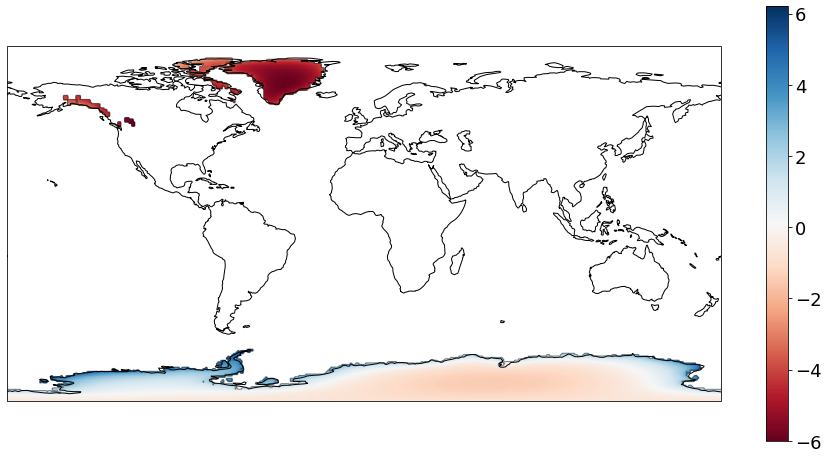

percentage difference from GMSL =  -1.7600056451739925 %


In [186]:
# set the adjoint loads
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.sea_altimetry_load(sl0,ice0,cosine = True)

SL.plot(zeta_d)

# solve the generalised fingerprint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)

# form the sea surface height directly
ssh = sl + u + psi/SL.g

# set the observational area and form the average
ssh_direct = SL.surface_integral(ssh*zeta_d)

# compute the lhs of the reciprocity relation
lhs = SL.surface_integral(sl_d*zeta)

# compute the rhs of the reciprocity relation
rhs =  SL.surface_integral(zeta_d*sl) - SL.surface_integral(zeta_u_d*u) \
       - SL.surface_integral(zeta_phi_d*(phi+psi))/SL.g - np.inner(kk_d,om)/SL.g

# print the values out along with the relative difference
print('')
print('direct ssh value     = ',ssh_direct)
print('left hand side       = ',lhs)
print('right hand side      = ',rhs)
print('relative difference  = ',np.abs((lhs-rhs)/lhs))
print('')


# plot the kernel wrt zeta
SL.plot(sl_d,title = 'sensitivity kernel for altimetry average')

# plot the kernel wrt I
K = SL.rhoi*(1-C)*sl_d*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(ice_mask*K,title = 'projected sensitivity kernel for altimetry average')

Kval = -SL.rhoi/(SL.rhow*A)
Ki = Kval*SL.ice_mask(sl0,ice0,val = 0.)
SL.plot(100*ice_mask*(K-Ki)/Kval,title = 'percentage difference with ideal kernel')

# determine the difference between the altimetry estimate the GMSL
print('percentage difference from GMSL = ',100*(ssh_direct-GMSL)/np.abs(GMSL),"%")





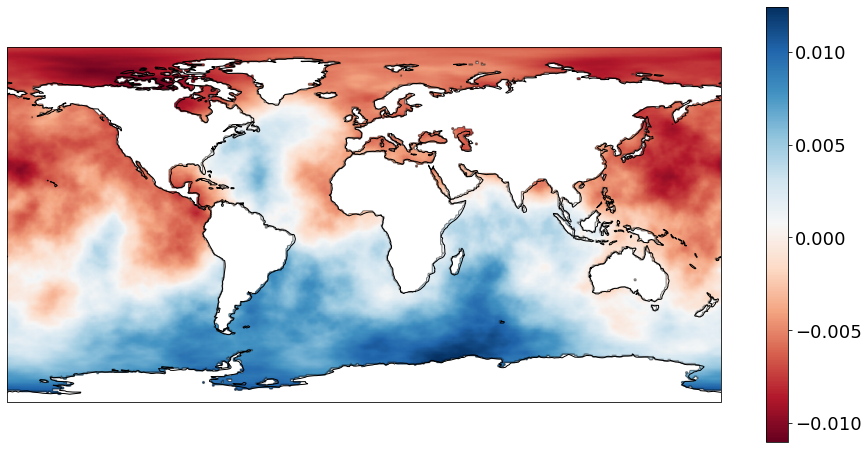

iteration =  1 relative change =  0.1876174116299615
iteration =  2 relative change =  0.03831242285008714
iteration =  3 relative change =  0.00785365508117328
iteration =  4 relative change =  0.0016110239218273597
iteration =  5 relative change =  0.0003301299427109106
iteration =  6 relative change =  6.754550859568464e-05
iteration =  7 relative change =  1.380328215712778e-05
iteration =  8 relative change =  3.0438018623329095e-06
iteration =  9 relative change =  6.91112508664983e-07
iteration =  10 relative change =  1.6162291367426413e-07
iteration =  11 relative change =  3.910038828206821e-08
iteration =  12 relative change =  9.820694101823628e-09


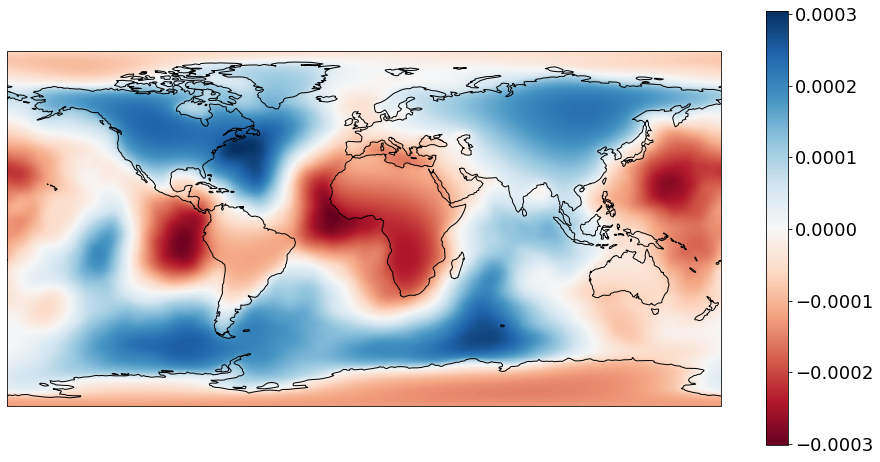

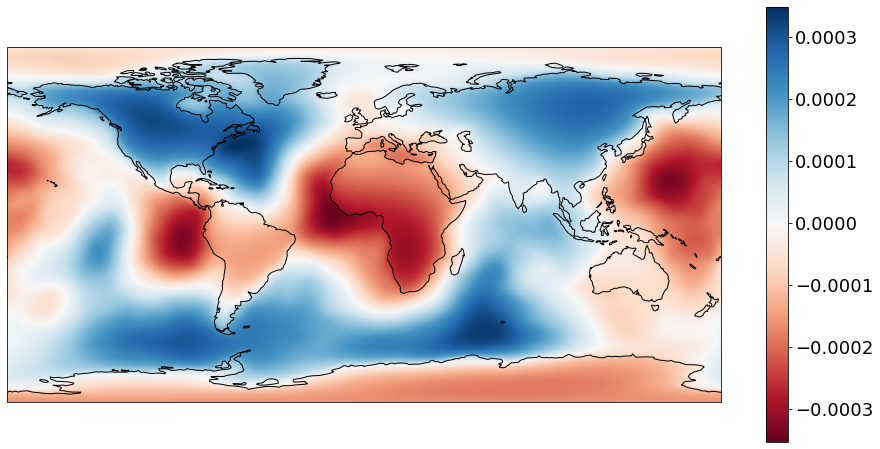

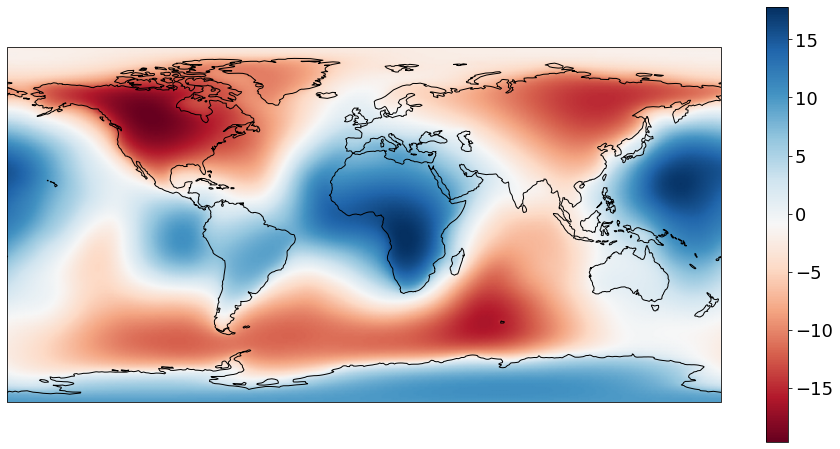

GRACE average of load =  0.0004063883864507318
true average of load  =  0.0021934083858360237
relative difference   =  -81.47228810307317 %
iteration =  1 relative change =  0.0800754021181947
iteration =  2 relative change =  0.008069180063021673
iteration =  3 relative change =  0.0010536175718929637
iteration =  4 relative change =  0.000175468733447438
iteration =  5 relative change =  3.567431295633505e-05
iteration =  6 relative change =  8.296195708367165e-06
iteration =  7 relative change =  2.0875146745525484e-06
iteration =  8 relative change =  5.551435839443288e-07
iteration =  9 relative change =  1.543473327891422e-07
iteration =  10 relative change =  4.528073105311858e-08
iteration =  11 relative change =  1.3692693418243838e-08
iteration =  12 relative change =  4.212463724811113e-09


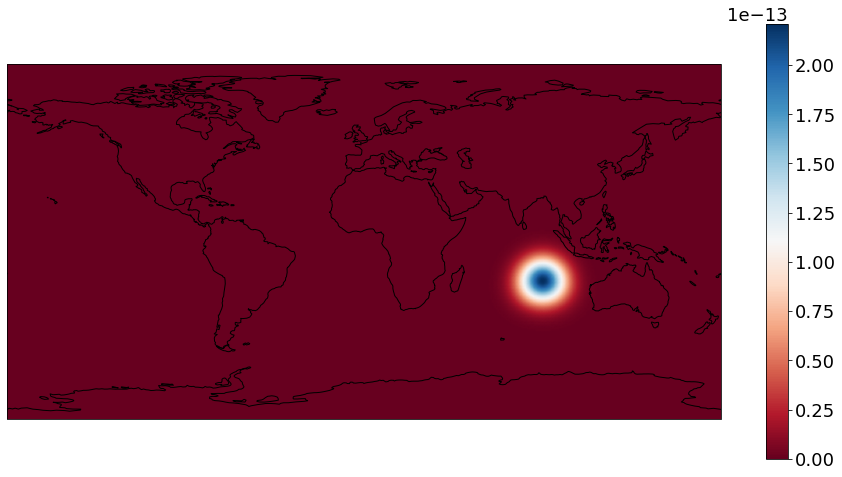

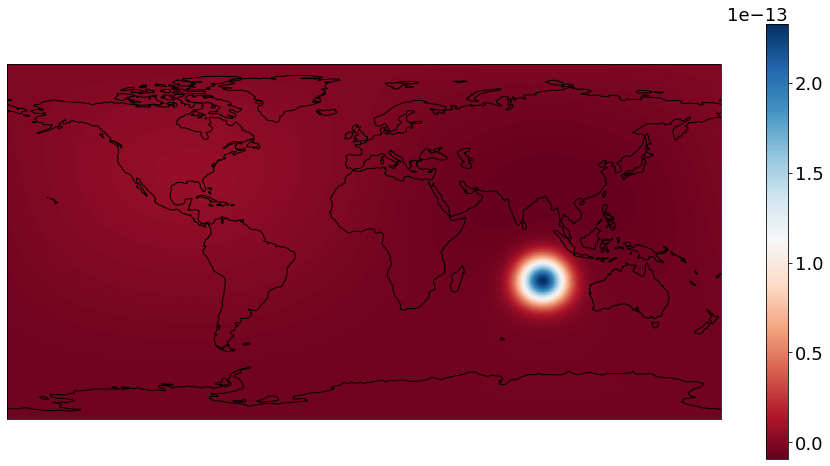

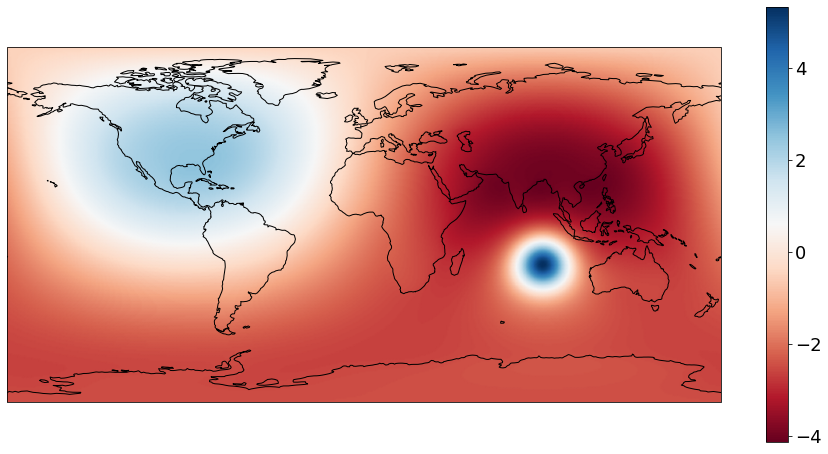

In [187]:
# make a random ocean load
Q = SL.sobolev_covariance(L,std = 0.01,s = 2,mu = 1.)
#Q = SL.heat_covariance(L,std = 0.01,mu = 0.3)
zeta_dyn = SL.random_ocean_load(C,Q)
sl_dyn = zeta_dyn/SL.rhow
SL.plot(ocean_mask*sl_dyn)

# compute the simplified response
_,phi_dir = SL.loading_response(zeta_dyn)


# compute the response
g = SL.g
sl_hyd,u_hyd,phi_hyd,om_hyd,psi_hyd = SL.fingerprint(C,zeta_dyn)
SL.plot(-(1/g)*phi_dir)
SL.plot(-(1/g)*phi_hyd)
norm = np.max(np.abs(phi_hyd.data))
SL.plot(100*(phi_hyd-phi_dir)/norm)


# set the averaging function
w = SL.circular_averaging_function(L,r = 1000,lat0 = -20.,lon0 = 90.)

# compute the true and GRACE average
true_average = SL.surface_integral(w*zeta_dyn)/SL.rhow
GRACE_average = SL.GRACE_average_measurement(phi_hyd,w,LT = 0)/SL.rhow

print('GRACE average of load = ',GRACE_average)
print('true average of load  = ',true_average)
print('relative difference   = ',100*(GRACE_average-true_average)/true_average,'%')

# form the adjoint loads
zeta_d, zeta_u_d, zeta_phi_d, kk_d  = SL.GRACE_average_load(w,LT = 0)

# solve the adjoint problem
sl_d,_,_,_,_ = SL.generalised_fingerprint(C,zeta_d,zeta_u_d,zeta_phi_d,kk_d)


# plot the kernel wrt zeta
SL.plot(w,title = 'GRACE averaging kernel')
SL.plot(sl_d,title = 'sensitivity kernel for GRACE average wrt direct load')

# plot the kernel wrt zeta
norm = np.max(np.abs(w.data[:,:]))
SL.plot(100*(sl_d-w)/norm,title = 'percentage difference between the kernels')

